ir Static Structure Factor

The `freud.diffraction` module provides two methods for calculating a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) $S(k)$ which can be used to characterise structure of crystals, liquids or amorphous phases.

The `freud.diffraction.StaticStructureFactorDirect` class implements a "direct" $S(k)$ method, which operates on a k-space grid:

$$S(k) = {\frac{1}{N}}\sum_{i=1}^{N}\sum_{j=1}^{N}\mathrm{e}^{-i\mathbf{k}\cdot(\mathbf{r}_{i} - \mathbf{r}_{j})}$$

For an excellent introduction to the theory of scattering and $S(k)$, please refer to the documentation of the [dynasor package](https://dynasor.materialsmodeling.org/), which performs a number of calculations related to scattering. We have re-implemented the core method of static structure factor calculation from dynasor in **freud** with some additional performance optimizations in parallelized C++ code, as well as an interface to compute $S(k)$ that aligns with the APIs and conventions of the **freud** analysis library.

The `freud.diffraction.StaticStructureFactorDebye` class computes static structure factor based on the Debye scattering equation:

$$ S(k) = {\frac{1}{N}} \sum_{i=1}^{N}\sum_{j=1}^{N}{\frac{\sin(kr_{ij})}{kr_{ij}}} $$

which is obtained by integrating out the angular dependence from the original formula. This implementation provides a much faster algorithm, but gives worse results than the "direct" method at low-k values.

Note that freud employs the usual physics convention, as opposed to the crystallographic convetion, with following expression linking the two: $k = 2\pi q$. Static structure factor is related to the radial distribution function, $g(r)$, by a Fourier Transform, i.e.

$$ S(k) = 1 + \rho \int_{V}\mathrm{d}\mathbf{r}e^{-i\mathbf{k}\cdot\mathbf{r}}g(r). $$

## Lennard-Jones liquid example

One of the use cases for $S(k)$ is to characterize structure of liquids. The example shown here uses points that were generated from a HOOMD-blue simulation of a 1000-particle system subject to the Lennard-Jones potential, see HOOMD-blue [documentation](https://hoomd-blue.readthedocs.io/en/latest/) and [examples](https://github.com/glotzerlab/hoomd-examples).

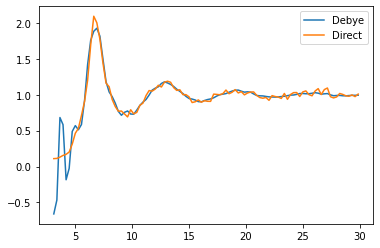

In [30]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np

bins = 100
k_max = 30
k_min = 3
sfDirect = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min
)
sfDebye = freud.diffraction.StaticStructureFactorDebye(
    bins=bins, k_max=k_max, k_min=k_min
)

with gsd.hoomd.open("data/LJsampletraj.gsd", "rb") as traj:
    for frame in traj:
        sfDebye.compute(frame, reset=False)
        sfDirect.compute(frame, reset=False)

plt.plot(sfDebye.bin_centers, sfDebye.S_k, label="Debye")
plt.plot(sfDirect.bin_centers, sfDirect.S_k, label="Direct")
plt.legend()
plt.show()

## Crystal comparsion example
Static structure factor $S(k)$ can also be used to characterize and compare crystal structures. In the below example we compare the computed static structure factors $S(k)$ of a face-centered cubic (fcc) crystal and simple cubic (sc) crystal.

<class 'numpy.ndarray'> [[ 0.08253574 -0.04485846 -0.12427568]
 [-0.06389141  0.01625299  1.1349893 ]
 [-0.0836134  -0.01250982  1.9470716 ]
 ...
 [-0.9194937  -1.073581   -3.1630516 ]
 [-0.9941435  -0.9134555  -2.0207226 ]
 [-1.0329866  -0.99403477 -0.9934497 ]]


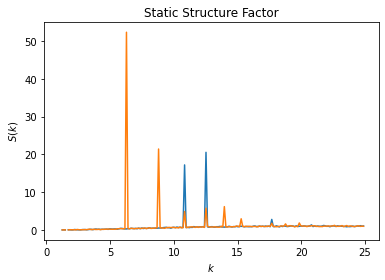

In [42]:
import freud
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sf = freud.diffraction.StaticStructureFactorDirect(bins=200, k_max=25, k_min=1)
fccsystem = freud.data.UnitCell.fcc().generate_system(10, sigma_noise=0.10)
sf.compute(fccsystem)
sf.plot(ax=ax)

scsystem = freud.data.UnitCell.sc().generate_system(10, sigma_noise=0.10)
box, points = scsystem
print(type(points), points)
sf.compute(scsystem)
sf.plot(ax=ax)

plt.show()

## Calculation of partial structure factors

Both methods support calculation of partial structure factors according to [Faber-Ziman decomposition](https://freud--821.org.readthedocs.build/en/820/modules/diffraction.html#freud.diffraction.StaticStructureFactorDirect) {***UPDATE LINK AFTER CLOSING PR***}{should we incluede the formula for decomposition here?}. In our implementation summation of partials reproduces the total scattering. In this example we load GeS$_2$ trajectory and calculate the Ge-Ge partial, the S-S partial and the mixed Ge-S partial (which is the same as S-Ge partial). The calculation of the partials requires the usage of `query_points` and `N_total` parameters for the compute method.

/tmp/ipykernel_21947/896173679.py:8: ConversionWarning: Some errors were detected !
    Line #261 (got 1 columns instead of 4)
    Line #521 (got 1 columns instead of 4)
    Line #781 (got 1 columns instead of 4)
    Line #1041 (got 1 columns instead of 4)
    Line #1301 (got 1 columns instead of 4)
    Line #1561 (got 1 columns instead of 4)
    Line #1821 (got 1 columns instead of 4)
    Line #2081 (got 1 columns instead of 4)
    Line #2341 (got 1 columns instead of 4)
  positions = np.genfromtxt("data/ges2.xyz", skip_header=2, invalid_raise=False)[
/tmp/ipykernel_21947/896173679.py:12: ConversionWarning: Some errors were detected !
    Line #261 (got 1 columns instead of 4)
    Line #521 (got 1 columns instead of 4)
    Line #781 (got 1 columns instead of 4)
    Line #1041 (got 1 columns instead of 4)
    Line #1301 (got 1 columns instead of 4)
    Line #1561 (got 1 columns instead of 4)
    Line #1821 (got 1 columns instead of 4)
    Line #2081 (got 1 columns instead of 4)
    Lin

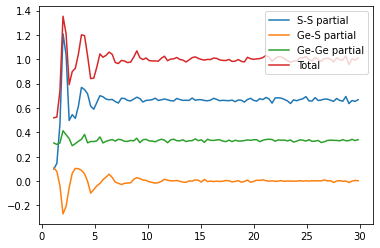

In [66]:
import freud
import matplotlib.pyplot as plt
import numpy as np

# read in xyz file

N_part = int(np.genfromtxt("data/ges2.xyz", max_rows=1, dtype=int))
positions = np.genfromtxt("data/ges2.xyz", skip_header=2, invalid_raise=False)[
    :, 1:4
].reshape(-1, N_part, 3)

atom_type = np.genfromtxt(
    "data/ges2.xyz", skip_header=2, invalid_raise=False, dtype=str
)[:, 0].reshape(-1, N_part)

box = freud.box.Box.from_box([19.21, 19.21, 19.21, 0, 0, 0])

# take the last frame
points = positions[-1]
atypes_last_frame = atom_type[-1]
Ge_points = np.asarray(points[atypes_last_frame == "Ge"]).astype(np.float32)
S_points = np.asarray(points[atypes_last_frame == "S"]).astype(np.float32)

# max_k_points is the number of k-points used in the calculation, higher values give better S(k) but takes longer
max_k_points = 200000
sf = freud.diffraction.StaticStructureFactorDirect(
    bins=100, k_max=30, k_min=1, max_k_points=max_k_points
)

sf.compute((box, S_points), query_points=S_points, N_total=N_part)
plt.plot(sf.bin_centers, sf.S_k, label="S-S partial")
S_ss = sf.S_k
sf.compute((box, S_points), query_points=Ge_points, N_total=N_part)
plt.plot(sf.bin_centers, sf.S_k, label="Ge-S partial")
S_sg = sf.S_k
sf.compute((box, Ge_points), query_points=Ge_points, N_total=N_part)
plt.plot(sf.bin_centers, sf.S_k, label="Ge-Ge partial")
S_gg = sf.S_k
S_tot = S_ss + S_sg + S_gg
plt.plot(sf.bin_centers, S_tot, label="Total")
plt.legend(loc="upper right")
plt.show()